# Step 1. EDA

In [1]:
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

c:\Users\kurom\anaconda3\envs\dl-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
financial_news = pd.read_csv('all-data.csv', encoding='latin', header=None) #read csv set header to none because columns have no title
financial_news.rename(columns={0: 'label', 1:'news'}, inplace=True) #rename columns

In [3]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [4]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [5]:
#Check information of df
#we can see there is no missing values 
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


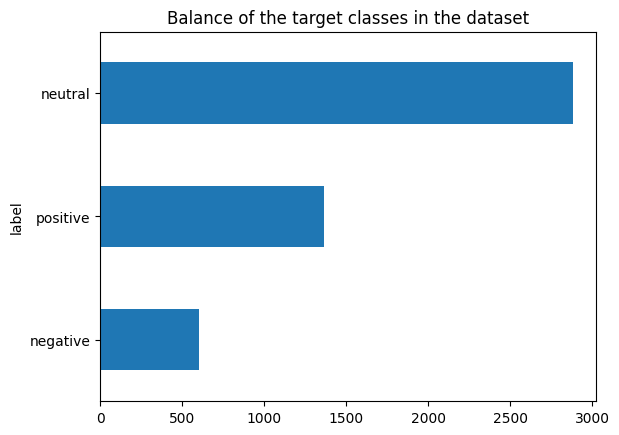

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [6]:
#Check balance of the data set
financial_news['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news['label'].value_counts())

In [7]:
#Check the maximum lenght of the documents
financial_news['len'] = financial_news['news'].apply(lambda text: len(text.split()))
financial_news['len'].max()

81

In [8]:
financial_news.drop(columns={'len'}, inplace=True)
financial_news.head(3)

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


# Step 2. Pre-processing

### Approach 1. do not balance classes

In [9]:
#First let's map the labels to integers

lable_map = {'negative': 2, 'neutral': 0, 'positive': 1}
financial_news['label'] = financial_news['label'].map(lable_map)
financial_news.head()

,label,news
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


In [10]:
#Save approach 1 dataframe to folder
financial_news.to_csv('data/financial_news_1.csv', index=False)

### Approach 2. Downsampling

In [11]:
# Let's downsample positive and neutral labels to create a balanced data set
financial_news_ds = financial_news.copy() # Copy DF

#Now let's separate our 3 classes to perform downsample
financial_news_n = financial_news_ds.loc[financial_news_ds.label == 2] #Negative label
financial_news_0 = financial_news_ds.loc[financial_news_ds.label ==  0] #Neutral label
financial_news_1 = financial_news_ds.loc[financial_news_ds.label ==  1] #Positive label 

In [12]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1], dtype=int64)

In [13]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0 = financial_news_0.iloc[0:604, :]
financial_news_1 = financial_news_1.iloc[0:604, :]

In [14]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [15]:
#put everything together again
financial_news_ds = pd.concat([financial_news_n, financial_news_0, financial_news_1])

#shuffle rows and reset index
financial_news_ds = financial_news_ds.sample(frac=1).reset_index(drop=True)

#check df
financial_news_ds.tail()

,label,news
1807,1,Finnish electronics manufacturing services com...
1808,1,"ADPnews - Jun 30 , 2009 - Finnish stainless st..."
1809,1,The growth in the activeness of Talentum 's cu...
1810,1,"( ADP News ) - Feb 11 , 2009 - Finnish managem..."
1811,2,Finnair 's total traffic decreased by 8.7 % in...


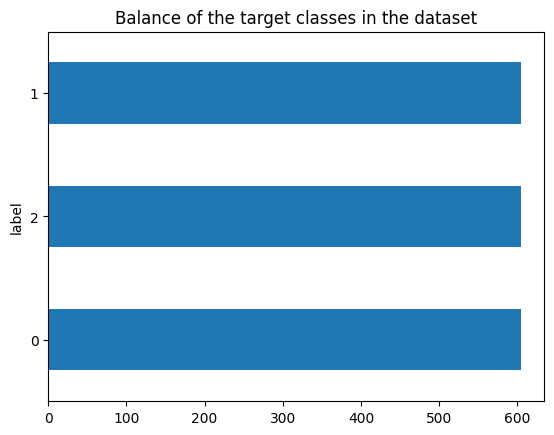

label
0    604
2    604
1    604
Name: count, dtype: int64


In [16]:
#Check balance of the data set
financial_news_ds['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news_ds['label'].value_counts())

In [17]:
#save approach 2 dataframe 
financial_news_ds.to_csv('data/financial_news_2.csv', index=False)

# Step 3. Feature extraction

## Feature Extraction for Transfer Learning
### Ignore this section for this notebook

In [18]:
# Load raw data set
from datasets import load_dataset
from datasets import DatasetDict
raw_dataset_1 = load_dataset('csv', data_files='data/financial_news_1.csv')
raw_dataset_2 = load_dataset('csv', data_files='data/financial_news_2.csv')

Generating train split: 4846 examples [00:00, 164823.97 examples/s]
Generating train split: 1812 examples [00:00, 159695.72 examples/s]


In [19]:
#Check raw data sets
raw_dataset_1
raw_dataset_2

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 1812
    })
})

In [20]:
#Create train, test and validation splits

#First split into train/test 30% for split, and specify seed
train_test_split_1 = raw_dataset_1['train'].train_test_split(test_size=0.2, seed=18)
train_test_split_2 = raw_dataset_2['train'].train_test_split(test_size=0.2, seed=18)

#Now split into train/test/val making 40% of test data for validation and specify seed
train_test_val_split_1 = train_test_split_1['test'].train_test_split(test_size=0.4, seed=18)
train_test_val_split_2 = train_test_split_2['test'].train_test_split(test_size=0.4, seed=18)

#Gather everything into single dataset dicts
train_test_val_split_1 = DatasetDict({'train': train_test_split_1['train'], 'test': train_test_val_split_1['train'], 'valid': train_test_val_split_1['test']})
train_test_val_split_2 = DatasetDict({'train': train_test_split_2['train'], 'test': train_test_val_split_2['train'], 'valid': train_test_val_split_2['test']})

train_test_val_split_1

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news'],
        num_rows: 388
    })
})

In [21]:
# For fine tuning a pre trained model we are choosing to use distilBERT since it's lighter than other BERT based models while conserving the vast majority of BERT's performance

# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
#Define function to tokenize data in a batch which should be a dictionary like object containing data to be tokenized
def to_tokens(batch):
    return tokenizer(batch['news'], truncation=True, padding=True)

In [23]:
#Now tokenize data from the data sets:
tokenized_split_1 = train_test_val_split_1.map(to_tokens, batched=True)
tokenized_split_2 = train_test_val_split_2.map(to_tokens, batched=True)

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map: 100%|██████████| 146/146 [00:00<00:00, 3370.48 examples/s]


In [24]:
tokenized_split_1

DatasetDict({
    train: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news', 'input_ids', 'attention_mask'],
        num_rows: 388
    })
})

## Feature Extraction for Training an LSTM model from scratch

In [60]:
#For this approach we will use Word2Vec Google negative 300 bin file. 
#Since this file was trained on news it should make sense to make feature extraction for news headlines
#import libraries
from gensim.models import Word2Vec, KeyedVectors

#Read bin file
#Word2Vec
data_path = 'C:/Users/kurom/Desktop/AI_GBC/S2/AppMath_DL/GoogleNews-vectors-negative300.bin'

#load Word2Vec Model
word2vec_model = KeyedVectors.load_word2vec_format(data_path, binary=True)

In [61]:
#Read data sets
w2v_dataset_1 = pd.read_csv('data/financial_news_1.csv')
w2v_dataset_2 = pd.read_csv('data/financial_news_2.csv')

w2v_dataset_1.head()
w2v_dataset_2.head()

,label,news
0,0,Ponsse plans to create a network that is based...
1,2,Ramirent made 18 million kroons EUR 1.15 mln l...
2,0,"According to Vauramo , the plant 's lifting eq..."
3,2,The company said that its comparable operating...
4,1,Net sales surged by 30 % to EUR 36 million .


In [62]:
#Get a list of list of the news cleaned from non alphabet characters
list_of_list_news_1 = [w2v_dataset_1.loc[i, ['news']].iloc[0].split() for i in range(len(w2v_dataset_1['news']))]
list_of_list_news_2 = [w2v_dataset_2.loc[i, ['news']].iloc[0].split() for i in range(len(w2v_dataset_2['news']))]

In [63]:
list_of_list_news_1[0]

['According',
 'to',
 'Gran',
 ',',
 'the',
 'company',
 'has',
 'no',
 'plans',
 'to',
 'move',
 'all',
 'production',
 'to',
 'Russia',
 ',',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing',
 '.']

In [64]:
#Clean each new from non alphabet characters
import re
regex = re.compile('[^a-zA-Z]')

re_list_of_lists_1 = []
for i in range(len(list_of_list_news_1)):
    temp = [regex.sub('', list_of_list_news_1[i][token]) for token in range(len(list_of_list_news_1[i]))]
    temp = list(filter(lambda a: a != '', temp))
    re_list_of_lists_1.append(temp)

re_list_of_lists_2 = []
for i in range(len(list_of_list_news_2)):
    temp = [regex.sub('', list_of_list_news_2[i][token]) for token in range(len(list_of_list_news_2[i]))]
    temp = list(filter(lambda a: a != '', temp))
    re_list_of_lists_2.append(temp)

In [65]:
re_list_of_lists_1[0]

['According',
 'to',
 'Gran',
 'the',
 'company',
 'has',
 'no',
 'plans',
 'to',
 'move',
 'all',
 'production',
 'to',
 'Russia',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing']

In [66]:
#Extract Features using Word2Vec
def embbeding_word_feats(list_of_lists):
    #DIMENSION = 300 #Dimension of the vectors that represent word (embbedings)
    #zero_vector = np.zeros(DIMENSION) #zero vector
    feats = []
    corpus = list_of_lists
    for doc in corpus:
        feats_for_doc = []
        for token in doc:
            if token in word2vec_model:
                feats_for_doc.append(word2vec_model[token])
        feats.append(feats_for_doc)
    return feats

In [67]:
w2v_embbedings_1 = embbeding_word_feats(re_list_of_lists_1)
w2v_embbedings_2 = embbeding_word_feats(re_list_of_lists_2)

In [68]:
#Sanity checkk
print(w2v_dataset_1.shape)
print(len(w2v_embbedings_1))
print(len(w2v_embbedings_1[0]))
print(len(w2v_embbedings_1[0][1]))

(4846, 2)
4846
19
300


In [69]:
#Right the number of tokens in each document is different so we need to padd them to be able to feed them to the LSTM nn

#Check the maximum number of tokens in documents across the corpus
temp_1 = [len(w2v_embbedings_1[i]) for i in range(len(w2v_embbedings_1))]
print(max(temp_1))

temp_2 = [len(w2v_embbedings_2[i]) for i in range(len(w2v_embbedings_2))]
print(max(temp_2))

45
45


In [70]:
#Pad the number of tokens in documents
def padding_embbedings(list_of_lists, pad_to=45):
    DIMENSION = 300 #Dimension of the vectors that represent word (embbedings)
    zero_vector = np.zeros(DIMENSION) #zero vector
    feats = []
    corpus = list_of_lists
    for doc in corpus:
        padded_doc = doc.copy()
        if len(doc) < pad_to:
            a = pad_to - len(doc)
            for i in range(a):
                padded_doc.append(zero_vector)
        feats.append(padded_doc)
    return feats


In [71]:
w2v_embbedings_1 = padding_embbedings(w2v_embbedings_1, pad_to=45)
w2v_embbedings_2 = padding_embbedings(w2v_embbedings_2, pad_to=45)

In [72]:
#Sanity checkk
print(w2v_dataset_2.shape)
print(len(w2v_embbedings_2))
print(len(w2v_embbedings_2[0]))
print(len(w2v_embbedings_2[0][1]))

(1812, 2)
1812
45
300


In [73]:
import tensorflow as tf
#Now cast to np array
X_1 = np.array(w2v_embbedings_1)
X_2 = np.array(w2v_embbedings_2)

#Transform y into on hot encoded labels
#lable_map = {2: np.array([1,0,0]), 0:np.array([0,1,0]), 1:np.array([0,0,1])}

#y_1 = np.array(w2v_dataset_1['label'].map(lable_map))
#y_2 = np.array(w2v_dataset_2['label'].map(lable_map))

y_1 = tf.keras.utils.to_categorical(w2v_dataset_1['label'], num_classes=3)
y_2 = tf.keras.utils.to_categorical(w2v_dataset_2['label'], num_classes=3)


#Finally let's do tran val test split
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=18)
X_test_1, X_val_1, y_test_1, y_val_1 = train_test_split(X_test_1, y_test_1, test_size=0.4, random_state=18)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=18)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.4, random_state=18)

In [74]:
#Sanity check
X_train_1.shape

(3876, 45, 300)

In [75]:
y_train_1.shape

(3876, 3)

# Step 4 Training

### Approach 2. Train an LSTM model from scratch

In [76]:
from keras import layers
from keras import optimizers
from keras.layers import Dropout
from keras.models import Sequential
import time

#Define LSTM architechture for imbalanced dataset
lstm_model_1 = Sequential()
lstm_model_1.add(layers.LSTM(units=32, return_sequences=False, input_shape=(X_train_1.shape[1], X_train_1.shape[2]), activation="sigmoid" )) #add first layer for lstm
lstm_model_1.add(Dropout(0.2)) #Dropout for regularization
#lstm_model_1.add(layers.LSTM(units=32, return_sequences=False, activation="tanh") ) #add second lstm layer
#lstm_model_1.add(Dropout(0.2)) #Dropout for regularization
lstm_model_1.add(layers.Dense(3, activation='softmax')) #Final layer for multiclass prediction

#optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
lstm_model_1.compile(optimizer='adam', loss='categorical_crossentropy')
start = time.time()
lstm_history_1 = lstm_model_1.fit(X_train_1, y_train_1, epochs=30, batch_size=32, validation_data=(X_val_1, y_val_1))
end = time.time()
print("Process execution time :", round(end-start, 2))

Epoch 1/20

122/122 [==============================] - 6s 25ms/step - loss: 1.0003 - val_loss: 0.9230
Epoch 2/20
122/122 [==============================] - 3s 21ms/step - loss: 0.9439 - val_loss: 0.9231
Epoch 3/20
122/122 [==============================] - 3s 22ms/step - loss: 0.9424 - val_loss: 0.9292
Epoch 4/20
122/122 [==============================] - 4s 33ms/step - loss: 0.9444 - val_loss: 0.9194
Epoch 5/20
122/122 [==============================] - 4s 35ms/step - loss: 0.9361 - val_loss: 0.9238
Epoch 6/20
122/122 [==============================] - 3s 22ms/step - loss: 0.9360 - val_loss: 0.9201
Epoch 7/20
122/122 [==============================] - 3s 23ms/step - loss: 0.9352 - val_loss: 0.9274
Epoch 8/20
122/122 [==============================] - 3s 23ms/step - loss: 0.9348 - val_loss: 0.9205
Epoch 9/20
122/122 [==============================] - 2s 19ms/step - loss: 0.9296 - val_loss: 0.9180
Epoch 10/20
122/122 [==============================] - 2s 16ms/step - loss: 0.9221 - val_l

In [77]:
#Define LSTM architechture for imbalanced dataset
import time
lstm_model_2 = Sequential()
lstm_model_2.add(layers.LSTM(units=32, return_sequences=False, input_shape=(X_train_2.shape[1], X_train_2.shape[2]), activation="sigmoid" )) #add first layer for lstm
lstm_model_2.add(Dropout(0.2)) #Dropout for regularization
#lstm_model_2.add(layers.LSTM(units=32, return_sequences=False, activation="tanh") ) #add second lstm layer
#lstm_model_2.add(Dropout(0.2)) #Dropout for regularization
lstm_model_2.add(layers.Dense(3, activation='softmax')) #Final layer for multiclass prediction

#optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
lstm_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start = time.time()
lstm_history_2 = lstm_model_2.fit(X_train_2, y_train_2, epochs=30, batch_size=10, validation_data=(X_val_2, y_val_2))
end = time.time()
print("Training process execution time :", round(end-start,2))

Epoch 1/30

145/145 [==============================] - 8s 17ms/step - loss: 1.1307 - accuracy: 0.3251 - val_loss: 1.1072 - val_accuracy: 0.2877
Epoch 2/30
145/145 [==============================] - 2s 13ms/step - loss: 1.1045 - accuracy: 0.3561 - val_loss: 1.1063 - val_accuracy: 0.3425
Epoch 3/30
145/145 [==============================] - 2s 13ms/step - loss: 1.1126 - accuracy: 0.3368 - val_loss: 1.1027 - val_accuracy: 0.3425
Epoch 4/30
145/145 [==============================] - 2s 16ms/step - loss: 1.1083 - accuracy: 0.3416 - val_loss: 1.0980 - val_accuracy: 0.3699
Epoch 5/30
145/145 [==============================] - 3s 18ms/step - loss: 1.1034 - accuracy: 0.3416 - val_loss: 1.1018 - val_accuracy: 0.2877
Epoch 6/30
145/145 [==============================] - 4s 27ms/step - loss: 1.1061 - accuracy: 0.3326 - val_loss: 1.0956 - val_accuracy: 0.3699
Epoch 7/30
145/145 [==============================] - 2s 16ms/step - loss: 1.1091 - accuracy: 0.3126 - val_loss: 1.0971 - val_accuracy: 0.369

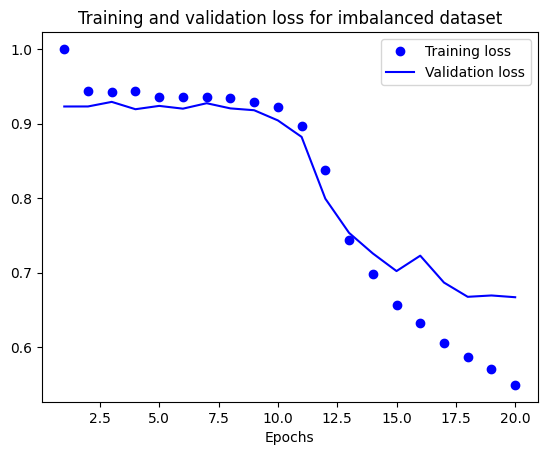

In [78]:
# Plot training and validation loss for imbalanced dataset
import matplotlib.pyplot as plt
loss = lstm_history_1.history['loss']
val_loss = lstm_history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss for imbalanced dataset')
plt.legend()
plt.show()

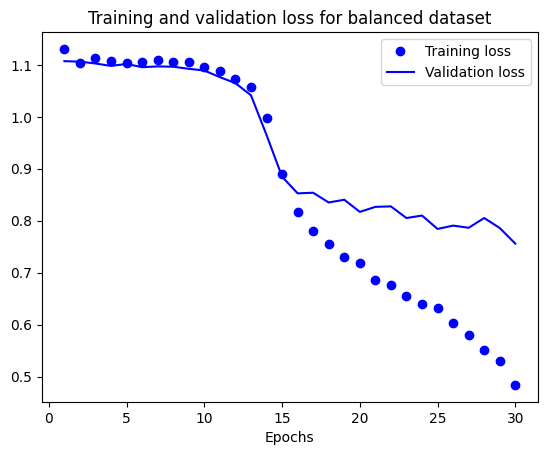

In [79]:
# Plot training and validation loss for imbalanced dataset
import matplotlib.pyplot as plt
loss = lstm_history_2.history['loss']
val_loss = lstm_history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss for balanced dataset')
plt.legend()
plt.show()

# Step 5 Evaluation

In [84]:
# make predictions
y_pred_1 = lstm_model_1.predict(X_test_1)
y_pred_2 = lstm_model_2.predict(X_test_2)

y_pred_1 = y_pred_1.argmax(axis=1)
y_pred_2 = y_pred_2.argmax(axis=1)

7/7 [==============================] - 0s 10ms/step


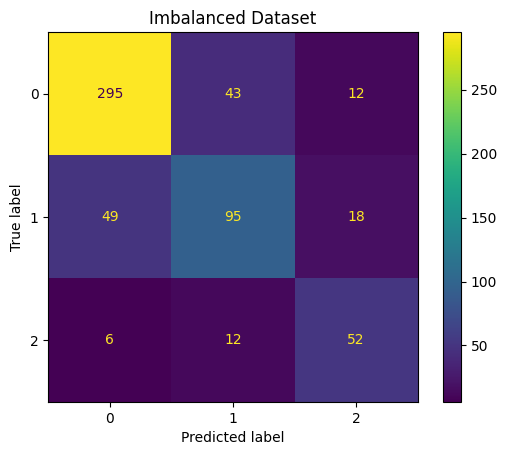

In [87]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_1.argmax(axis=1), y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Imbalanced Dataset')
plt.show()

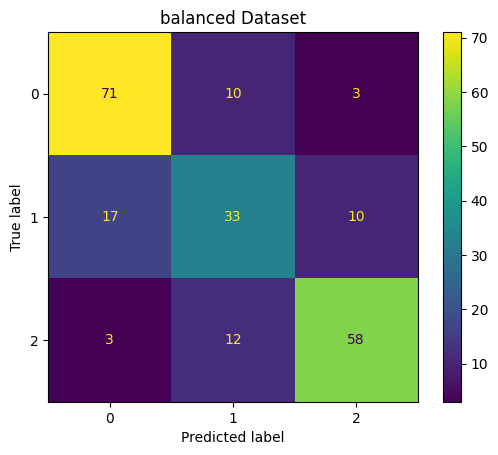

In [88]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_2.argmax(axis=1), y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('balanced Dataset')
plt.show()

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


print("Accuracy imbalanced data set :",np.round(accuracy_score(y_test_1.argmax(axis=1), y_pred_1), 2))
print("F1 Score imbalanced data set :",np.round(f1_score(y_test_2.argmax(axis=1), y_pred_2, average=None), 2))

print("Accuracy balanced data set :",np.round(accuracy_score(y_test_2.argmax(axis=1), y_pred_2), 2))
print("F1 Score balanced data set :",np.round(f1_score(y_test_2.argmax(axis=1), y_pred_2, average=None), 2))

Accuracy imbalanced data set : 0.76
F1 Score imbalanced data set : [0.81 0.57 0.81]
Accuracy balanced data set : 0.75
F1 Score balanced data set : [0.81 0.57 0.81]
